In [1]:
import collections
import csv
import dataclasses
import typing

import numpy

from matplotlib import pyplot
from numpy import random
from scipy import stats

In [2]:
_BASE_SEED = """This is chapter six, it's about the very basics of regression.
It demoes a simple regression with simulated data, and talks a little about
the history of the method.  It closes with some opinions about how to talk
about regression coefficients, as well as the famous etymologic phenomenon
'regression to the mean'."""

def _seed(s: str) -> int:
    return abs(hash(_BASE_SEED + s)) % (2 ** 32)

## 6.2, Programming fake-data simulation

> Write an R function to: (i) simulate $n$ data points from the model,
> $y = a + bx + \text{error}$, with data points $x$ uniformly sampled from the
> range (0, 100) and with errors drawn independently from the normal
> distribution with mean 0 and standard deviation $\sigma$; (ii) fit a linear
> regression to the simulated data; and (iii) make a scatterplot of the data
> and fitted regression line. Your function should take as arguments, $a$, $b$,
> $n$, $\sigma$, and it should return the data, print out the fitted regression,
> and make the plot. Check your function by trying it out on some values of $a$,
> $b$, $n$, $\sigma$.

Hm, one function returning all of these things is not a great design.  (Many of
the returned objects are just views of the upstream data.)

I'll make a class for this instead.

In [3]:
class SimpleRegression:
    """A dataset that demonstrates a simple univariate linear regression."""

    def __init__(self, a: float, b: float, n: int, sigma: float, seed: str | None):
        if n < 2:
            raise ValueError(f'n must be greater than 1; got {n}')
        if sigma <= 0:
            raise ValueError(f'sigma must be positive; got {sigma}')
        rng = random.default_rng() if seed is None else random.default_rng(seed=_seed(seed))
        self.xs = rng.uniform(low=0, high=100, size=n)
        self.ys = b * self.xs + rng.normal(loc=a, scale=sigma, size=n)
        self.model = stats.linregress(self.xs, self.ys)

    def plot(self, ax: pyplot.Axes):
        ax.plot(self.xs, self.ys, 'b.', label=f'N = {len(self.xs)}', zorder=10, alpha=0.6, markersize=4)
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        slope_lo = self.model.slope - 2 * self.model.stderr
        slope_hi = self.model.slope + 2 * self.model.stderr
        int_lo = self.model.intercept - 2 * self.model.intercept_stderr
        int_hi = self.model.intercept + 2 * self.model.intercept_stderr
        ax.set_title(
            f'Slope: [{slope_lo:0.2f}, {slope_hi:0.2f}],\n' +
            f'Intercept: [{int_lo:0.1f}, {int_hi:0.1f}]'
        )
        ax.plot(
            (0, 100),
            tuple(self.model.intercept + xi * self.model.slope for xi in (0, 100)),
            'r-',
            linewidth=1,
            zorder=11
        )
        m_lo = []
        m_hi = []
        for xi in range(0, 101):
            m_candidates = [
                slope_lo * xi + int_lo,
                slope_lo * xi + int_hi,
                slope_hi * xi + int_lo,
                slope_hi * xi + int_hi,
            ]
            m_lo.append(min(m_candidates))
            m_hi.append(max(m_candidates))
        ax.plot(tuple(range(0, 101)), m_lo, 'r--', linewidth=1)
        ax.plot(tuple(range(0, 101)), m_hi, 'r--', linewidth=1)
        ax.fill_between(tuple(range(0, 101)), m_lo, m_hi, color='red', alpha=0.1)
        ax.grid()
        ax.legend()

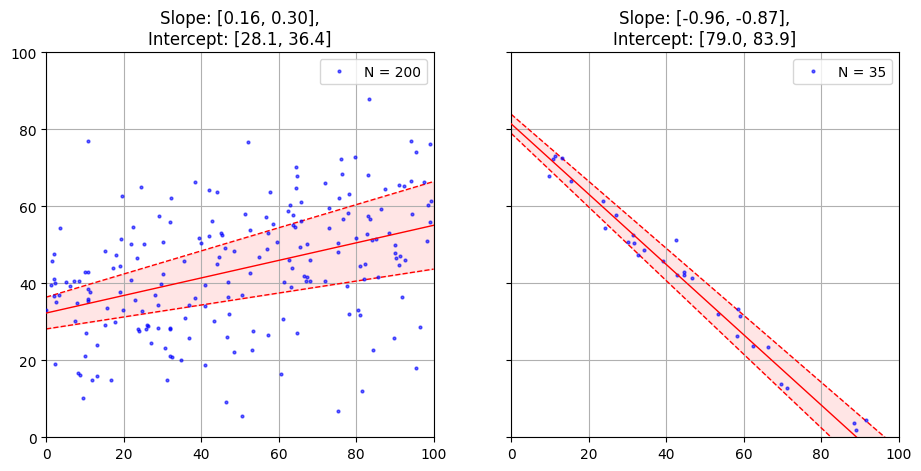

In [4]:
fig, axs = pyplot.subplots(nrows=1, ncols=2, sharey=True, figsize=(11,5))
SimpleRegression(a=30, b=0.25, n=200, sigma=15, seed='Exercise 6.2a').plot(axs[0])
SimpleRegression(a=80, b=-0.9, n=35, sigma=4, seed='Exercise 6.2b').plot(axs[1])

## 6.3, Variation, uncertainty, and sample size

> Repeat the example in Section 6.2, varying the number of data points, $n$.
> What happens to the parameter estimates and uncertainties when you increase
> the number of observations?

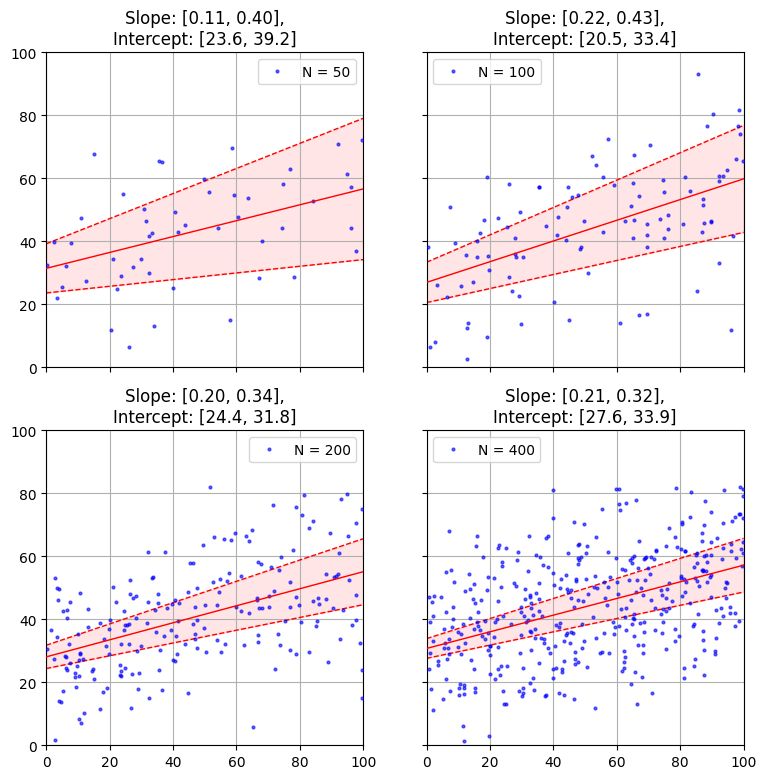

In [5]:
fig, axs = pyplot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(9,9))
for i, n in enumerate((50, 100, 200, 400)):
    SimpleRegression(a=30, b=0.25, n=n, sigma=15, seed=f'Exercise 6.3: n = {n}').plot(axs.ravel()[i])

## 6.4, Simulation study

> Perform the previous exercise more systematically, trying out a sequence of
> values of $n$, for each simulating fake data and fitting the regression to
> obtain estimate and uncertainty (median and mad sd) for each parameter. Then
> plot each of these as a function of $n$ and report on what you find.

I add a horizontal grey line that indicates the final estimate for each
parameter, the one arrived at for the largest sample, so we can whether it's
covered by the earlier uncertainty intervals (which: pretty much, yup).

Text(0.5, 0, 'Sample size')

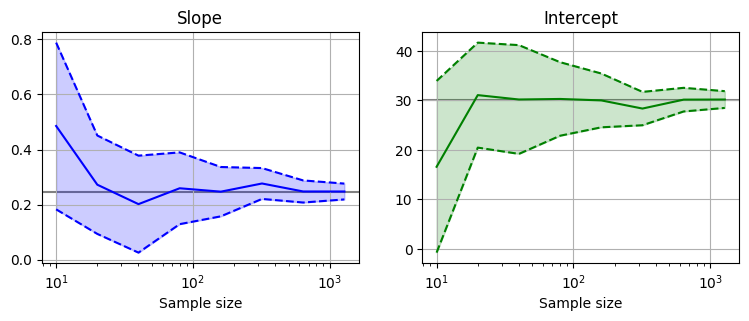

In [6]:
slope_lo = []
slope = []
slope_hi = []
int_lo = []
intercept = []
int_hi = []
ns = tuple([10, 20, 40, 80, 160, 320, 640, 1280])
for n in ns:
    regsim = SimpleRegression(a=30, b=0.25, n=n, sigma=15, seed='Exercise 6.4')
    slope_lo.append(regsim.model.slope - 2 * regsim.model.stderr)
    slope.append(regsim.model.slope)
    slope_hi.append(regsim.model.slope + 2 * regsim.model.stderr)
    int_lo.append(regsim.model.intercept - 2 * regsim.model.intercept_stderr)
    intercept.append(regsim.model.intercept)
    int_hi.append(regsim.model.intercept + 2 * regsim.model.intercept_stderr)
fig, axs = pyplot.subplots(ncols=2, figsize=(9, 3))

axs[0].semilogx(ns, slope, 'b-')
axs[0].semilogx(ns, slope_lo, 'b--')
axs[0].semilogx(ns, slope_hi, 'b--')
axs[0].fill_between(ns, slope_lo, slope_hi, color='b', alpha=0.2)
axs[0].grid()
axs[0].axhline(color='grey', y=slope[-1], zorder=0)
axs[0].set_title('Slope')
axs[0].set_xlabel('Sample size')

axs[1].semilogx(ns, intercept, 'g-')
axs[1].semilogx(ns, int_lo, 'g--')
axs[1].semilogx(ns, int_hi, 'g--')
axs[1].fill_between(ns, int_lo, int_hi, color='g', alpha=0.2)
axs[1].grid()
axs[1].axhline(color='grey', y=intercept[-1], zorder=0)
axs[1].set_title('Intercept')
axs[1].set_xlabel('Sample size')


## 6.5, Regression prediction and averages

> The heights and earnings data in Section 6.3 are in the folder `Earnings`.
> Download the data and compute the average height for men and women in the
> sample.
>
> (a) Use these averages and fitted regression model displayed on page 84 to
>     get a model-based estimate of the average earnings of men and of women in
>     the population.
>
> (b) Assuming 52% of adults are women, estimate the average earnings of adults
>     in the population.
>
> (c) Directly from the sample data compute the average earnings of men, women,
>     and everyone.  Compare these to the values calculated in parts (a) and
>     (b).

In [7]:
@dataclasses.dataclass(frozen=True)
class EarningsSubject:
    """Survey responses from an individual about their earnings."""
    height_inches: int
    is_male: bool
    earnings_kusd: float

    def __post_init__(self):
        if self.height_inches < 12:
            raise ValueError(f'Inadmissably low height: {self.height_inches}')

    @classmethod
    def from_csv_row(cls, row: dict[str, str]) -> 'EarningsSubject':
        return EarningsSubject(
            height_inches=int(row['height']),
            is_male=(row['male'] == '1'),
            earnings_kusd=float(row['earnk'])
        )

In [8]:
with open('/home/bgawalt/ros/datasets/earnings.csv') as infile:
    all_earnings = [EarningsSubject.from_csv_row(row) for row in csv.DictReader(infile)]

In [9]:
# Partition the records by gender
men = [subj for subj in all_earnings if subj.is_male]
women = [subj for subj in all_earnings if not subj.is_male]

In [10]:
# Average height -> model-based estimate of average earnings
men_height_avg = float(sum(man.height_inches for man in men))/len(men)
women_height_avg = float(sum(woman.height_inches for woman in women))/len(women)

men_earnk_avg_model = -26 + 0.6 * men_height_avg + 10.6
women_earnk_avg_model = -26 + 0.6 * women_height_avg
all_earnk_avg_model = 0.52 * women_earnk_avg_model + 0.48 * men_earnk_avg_model

In [11]:
# Now using sample means:
men_earnk_avg = sum(man.earnings_kusd for man in men)/len(men)
women_earnk_avg = sum(woman.earnings_kusd for woman in women)/len(women)
all_earnk_avg = sum(subj.earnings_kusd for subj in all_earnings)/len(all_earnings)

In [12]:
print('| Category | Model | Sample |')
print('| -------- | ----- | ------ |')
print(f'| Men      | {men_earnk_avg_model:0.1f}  | {men_earnk_avg:0.1f}   |')
print(f'| Women    | {women_earnk_avg_model:0.1f}  | {women_earnk_avg:0.1f}   |')
print(f'| All      | {all_earnk_avg_model:0.1f}  | {all_earnk_avg:0.1f}   |')

| Category | Model | Sample |
| -------- | ----- | ------ |
| Men      | 26.7  | 30.1   |
| Women    | 12.7  | 15.8   |
| All      | 19.4  | 21.1   |


## 6.6, Selection on x or y

> (a) Repeat the analysis in Section 6.4 using the same data, but just analyzing
>     the observations for mothers’ heights less than the mean. Confirm that the
>     estimated regression parameters are roughly the same as were obtained by
>     fitting the model to all the data.
>
> (b) Repeat the analysis in Section 6.4 using the same data, but just analyzing
>     the observations for daughters’ heights less than the mean. Compare the
>     estimated regression parameters and discuss how they differ from what was
>     obtained by fitting the model to all the data.
>
> (c) Explain why selecting on daughters’ heights had so much more of an effect
>     on the fit than selecting on mothers’ heights.

In [13]:
@dataclasses.dataclass
class MotherDaughterHeights:
    row_id: int
    mother_inches: float
    daughter_inches: float

    @classmethod
    def from_txt_line(cls, line: str) -> 'MotherDaughterHeights':
        spline = line.split()
        if len(spline) != 3:
            raise ValueError(f'Only got {len(spline)} entries on some txt line.')
        return MotherDaughterHeights(
            row_id=int(spline[0].strip('"')),
            mother_inches=float(spline[1]),
            daughter_inches=float(spline[2]),
        )

In [14]:
with open('/home/bgawalt/ros/datasets/MotherDaughterHeights.txt') as infile:
    md_heights = [MotherDaughterHeights.from_txt_line(line) for line in infile.readlines()[1:]]

In [15]:
def analyze_shorties(extract_height: typing.Callable[[MotherDaughterHeights], float]):
    avg = sum(extract_height(mdh) for mdh in md_heights) / len(md_heights)
    print(f'Average: {avg:0.1f}')
    shorties = [mdh for mdh in md_heights if extract_height(mdh) < avg]
    xs = [shorty.mother_inches for shorty in shorties]
    ys = [shorty.daughter_inches for shorty in shorties]
    model = stats.linregress(xs, ys)
    print(f'(Intercept):   {model.intercept:0.1f} +/- {2 * model.intercept_stderr:0.1f}')
    print(f'mother_height: {model.slope:0.2f} +/- {2 * model.stderr:0.2f}')

In [16]:
xs = [mdh.mother_inches for mdh in md_heights]
ys = [mdh.daughter_inches for mdh in md_heights]
model = stats.linregress(xs, ys)
print('All records:')
print(f'(Intercept):   {model.intercept:0.1f} +/- {2 * model.intercept_stderr:0.1f}')
print(f'mother_height: {model.slope:0.2f} +/- {2 * model.stderr:0.2f}')

All records:
(Intercept):   33.0 +/- 1.4
mother_height: 0.46 +/- 0.02


In [17]:
print('Short mothers:')
analyze_shorties(lambda mdh: mdh.mother_inches)
print('\nShort daughters:')
analyze_shorties(lambda mdh: mdh.daughter_inches)

Short mothers:
Average: 63.9
(Intercept):   37.8 +/- 3.1
mother_height: 0.38 +/- 0.05

Short daughters:
Average: 62.5
(Intercept):   49.6 +/- 1.4
mother_height: 0.17 +/- 0.02


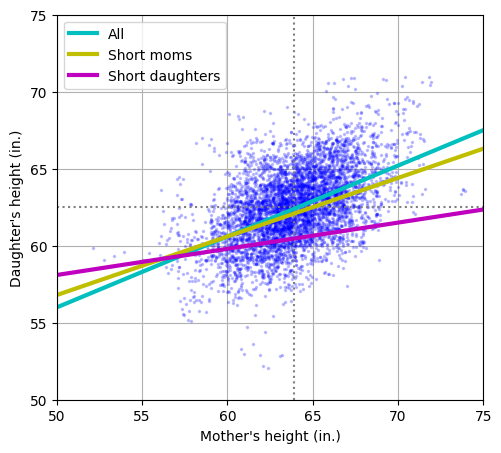

In [18]:
rng = random.default_rng(seed=_seed('Exercise 6.6'))
fig = pyplot.figure(figsize=(5.5, 5))
ax = fig.gca()
ax.plot(
    [mdh.mother_inches + rng.uniform(-0.5, 0.5) for mdh in md_heights],
    [mdh.daughter_inches + rng.uniform(-0.5, 0.5) for mdh in md_heights],
    'b.',
    alpha=0.2,
    markersize=3
)
ax.grid()
ax.axvline(x=63.9, color='tab:gray', linestyle=':')
ax.axhline(y=62.5, color='tab:gray', linestyle=':')
ax.set_xlabel("Mother's height (in.)")
ax.set_ylabel("Daughter's height (in.)")
ax.set_xlim(50, 75)
ax.set_ylim(50, 75)
ax.plot([50, 75], [33 + 0.46 * 50, 33 + 0.46 * 75], 'c', linewidth=3, label='All')
ax.plot([50, 75], [37.8 + 0.38 * 50, 37.8 + 0.38 * 75], 'y', linewidth=3, label='Short moms')
ax.plot([50, 75], [49.6 + 0.17 * 50, 49.6 + 0.17 * 75], 'm', linewidth=3, label='Short daughters')
ax.legend()

## 6.7, Regression to the mean

> Gather before-after data with a structure similar to the mothers’ and
> daughters’ heights in Sections 6.4 and 6.5. These data could be performance of
> athletes or sports teams from one year to the next, or economic outcomes in
> states or countries in two successive years, or any other pair of measurements
> taken on a set of items. Standardize each of the two variables so it has a
> mean of 0 and standard deviation of 1.
>
> (a) Following the steps of Section 6.4, read in the data, fit a linear
>     regression, and plot the data and fitted regression line.
>
> (b) Repeat the above steps with fake data that look similar to the data you
>     have gathered.

In [19]:
@dataclasses.dataclass(frozen=True)
class NFLPlayerIDPScores:
    """NFL player's regular-season-wide IDP fantasy football point total."""
    player_id: str
    name: str
    idp_2023: float
    idp_2024: float

    @classmethod
    def from_csv_row(cls, row: dict[str, str]) -> 'NFLPlayerIDPScores':
        return NFLPlayerIDPScores(
            player_id=row['player_id'],
            name=row['player_name'],
            idp_2023=float(row['idp_2023']),
            idp_2024=float(row['idp_2024']),
        )

In [20]:
with open('/home/bgawalt/ros/datasets/nfl_idp_scores.csv') as infile:
    idp_scores = [NFLPlayerIDPScores.from_csv_row(row) for row in csv.DictReader(infile)]

In [21]:
decent_idp_scores = [player for player in idp_scores
                     if player.idp_2023 >= 20 and player.idp_2024 >= 20]

In [28]:
log_xs = [numpy.log(player.idp_2023) for player in decent_idp_scores]
log_ys = [numpy.log(player.idp_2024) for player in decent_idp_scores]
xs = [player.idp_2023 for player in decent_idp_scores]
ys = [player.idp_2024 for player in decent_idp_scores]
model = stats.linregress(log_xs, log_ys)
print(f'(Intercept): {model.intercept:0.1f} +/- {2 * model.intercept_stderr:0.1f}')
print(f'idp_2023:    {model.slope:0.2f} +/- {2 * model.stderr:0.2f}')

(Intercept): 1.8 +/- 0.3
idp_2023:    0.59 +/- 0.06


Text(0.5, 1.0, 'Fantasy Football Regression to the Mean')

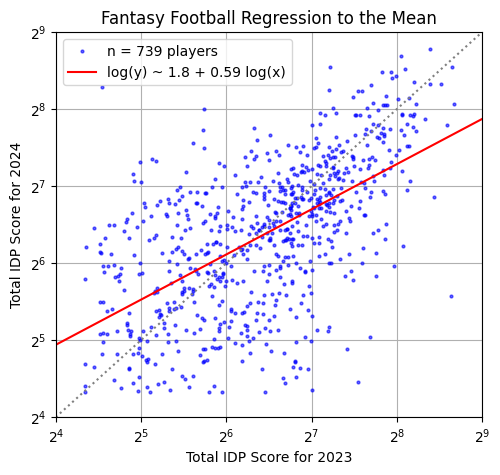

In [23]:
fig = pyplot.figure(figsize=(5.5, 5))
ax = fig.gca()
ax.loglog(xs, ys, 'b.', alpha=0.6, markersize=4, base=2, label=f'n = {len(xs)} players')
ax.loglog([16, 512], [16, 512], linestyle=':', color='tab:gray', base=2)
ax.loglog(
    [16, 512],
    [
        numpy.exp(model.intercept + model.slope * numpy.log(16)),
        numpy.exp(model.intercept + model.slope * numpy.log(512))
    ],
    'r-',
    base=2,
    label=f'log(y) ~ {model.intercept:0.1f} + {model.slope:0.2} log(x)'
)
ax.legend()
ax.set_xlim(16, 512)
ax.set_ylim(16, 512)
ax.grid()
ax.set_xlabel('Total IDP Score for 2023')
ax.set_ylabel('Total IDP Score for 2024')
ax.set_title('Fantasy Football Regression to the Mean')

## 6.8, Regression to the mean with fake data

> Perform a fake-data simulation as in Section 6.5, but using the flight school
> example on page 89. Simulate data from 500 pilots, each of whom performs two
> maneuvers, with each maneuver scored continuously on a 0–10 scale, that each
> pilot has a true ability that is unchanged during the two tasks, and that the
> score for each test is equal to this true ability plus independent errors.
> Further suppose that when pilots score higher than 7 on the scale during the
> first maneuver, that they get praised, and that scores lower than 3 on the
> first maneuver result in negative reinforcement. Also suppose, though, that
> this feedback has no effect on performance on the second task.
>
> (a) Make a scatterplot with one dot for each pilot, showing score on the
>     second maneuver vs. score on the first maneuver. Color the dots blue for
>     the pilots who got praised, red for those who got negative reinforcement,
>     and black for the other cases.
>
> (b) Compute the average change in scores for each group of pilots. If you did
>     your simulation correctly, the pilots who were praised did worse, on
>     average, and the pilots who got negative reinforcement improved, on
>     average, for the second maneuver. Explain how this happened, given that
>     your data were simulated under a model in which the positive and negative
>     messages had no effects.

In [24]:
rng = random.default_rng(seed=_seed('Exercise 6.8'))
def clamp(x: float) -> float:
    return max(min(x, 10), 0)
abilities = rng.uniform(1.5, 8.5, size=500)
errs_1 = stats.truncnorm.rvs(-2.4, 2.4, size=500, random_state=rng)
errs_2 = stats.truncnorm.rvs(-2.4, 2.4, size=500, random_state=rng)
scores_1 = [clamp(xi) for xi in (abilities + errs_1)]
scores_2 = [clamp(yi) for yi in (abilities + errs_2)]

In [25]:
model = stats.linregress(scores_1, scores_2)

Text(0, 0.5, 'Second maneuver score')

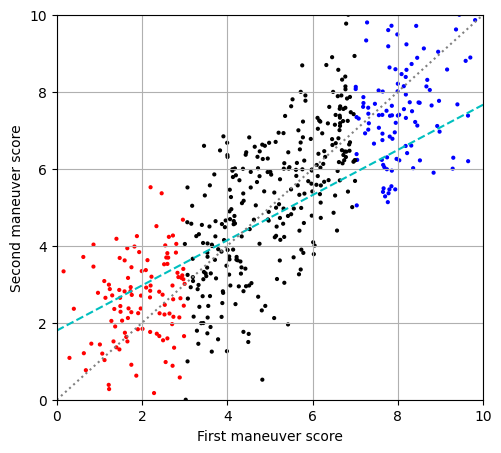

In [29]:
def color_code(score_1: float) -> str:
    if score_1 < 3:
        return 'r'
    if score_1 > 7:
        return 'b'
    return 'k'

colors = [color_code(si) for si in scores_1]
fig = pyplot.figure(figsize=(5.5, 5))
ax = fig.gca()
ax.scatter(scores_1, scores_2, c=colors, s=4)
ax.plot([0, 10], [model.intercept, model.intercept + 10 * model.slope], 'c--')
ax.plot([0, 10], [0, 10], linestyle=':', color='gray')
ax.grid()
ax.set_ylim(0, 10)
ax.set_xlim(0, 10)
ax.set_xlabel('First maneuver score')
ax.set_ylabel('Second maneuver score')

In [27]:
praise_deltas = [s2 - s1 for (s1, s2) in zip(scores_1, scores_2) if s1 > 7]
praise_avg = numpy.mean(praise_deltas)
yelled_at_deltas = [s2 - s1 for (s1, s2) in zip(scores_1, scores_2) if s1 < 3]
yelled_at_avg = numpy.mean(yelled_at_deltas)
print(f'Average praised change: {praise_avg:0.1f}')
print(f'Average yelled-at change: {yelled_at_avg:0.1f}')

Average praised change: -0.6
Average yelled-at change: 0.6
